# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='https://maet3608.github.io/nuts-ml/_images/cifar10.png' width=70% height=70% />

In [1]:
import torch
import numpy as np

# check if CUDA is available
# in order to make cuda available make sure that the runtime is changed to
# GPU by changing it in in Runtime-->Change Runtime type
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
# Load the data

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# number of subprocesses to use for data loading

num_workers = 0

batch_size = 20
# validation size 20% of training set
valid_size=0.2

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [4]:
# choose the training and test datasets
train_data = datasets.CIFAR10('~/drive/data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('~/drive/data', train=False,
                             download=True, transform=transform_test)

Extracting /root/drive/data/cifar-10-python.tar.gz to /root/drive/data
Files already downloaded and verified


In [5]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [6]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [7]:
# prepare data loaders (combine dataset and sampler)

train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                           sampler = train_sampler, num_workers= num_workers)
valid_sampler = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                            sampler = valid_sampler, num_workers = num_workers)

In [8]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size, num_workers= num_workers)

In [9]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
# visualize a batch of training data
import matplotlib.pyplot as plt
%matplotlib inline

# funtion to un-normalize the image
def imshow(img):
  img = img/2 + 0.5
  plt.imshow(np.transpose(img, (1,2,0))) # convert the tenosr shape[channels, width, height] to numpy [width, height, channels]

In [11]:
dataiter = iter(train_loader)

In [12]:
imgs, labels = dataiter.next()

In [13]:
type(imgs)

torch.Tensor

In [14]:
images = imgs.numpy()

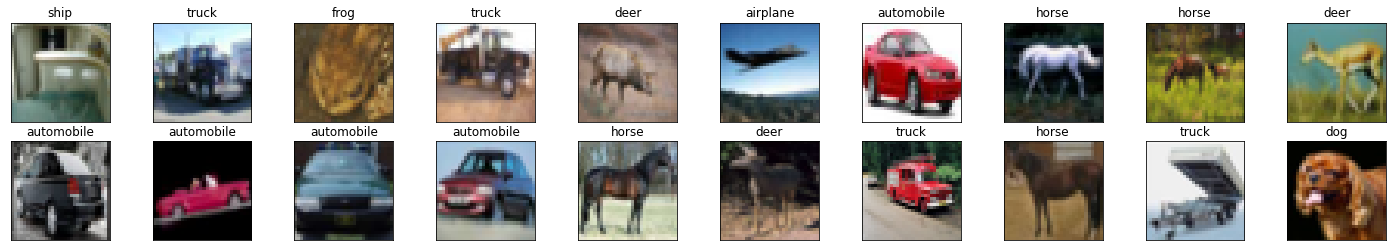

In [ ]:
# plot the images in the batch, along with corresponding label
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  #print(ax)
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

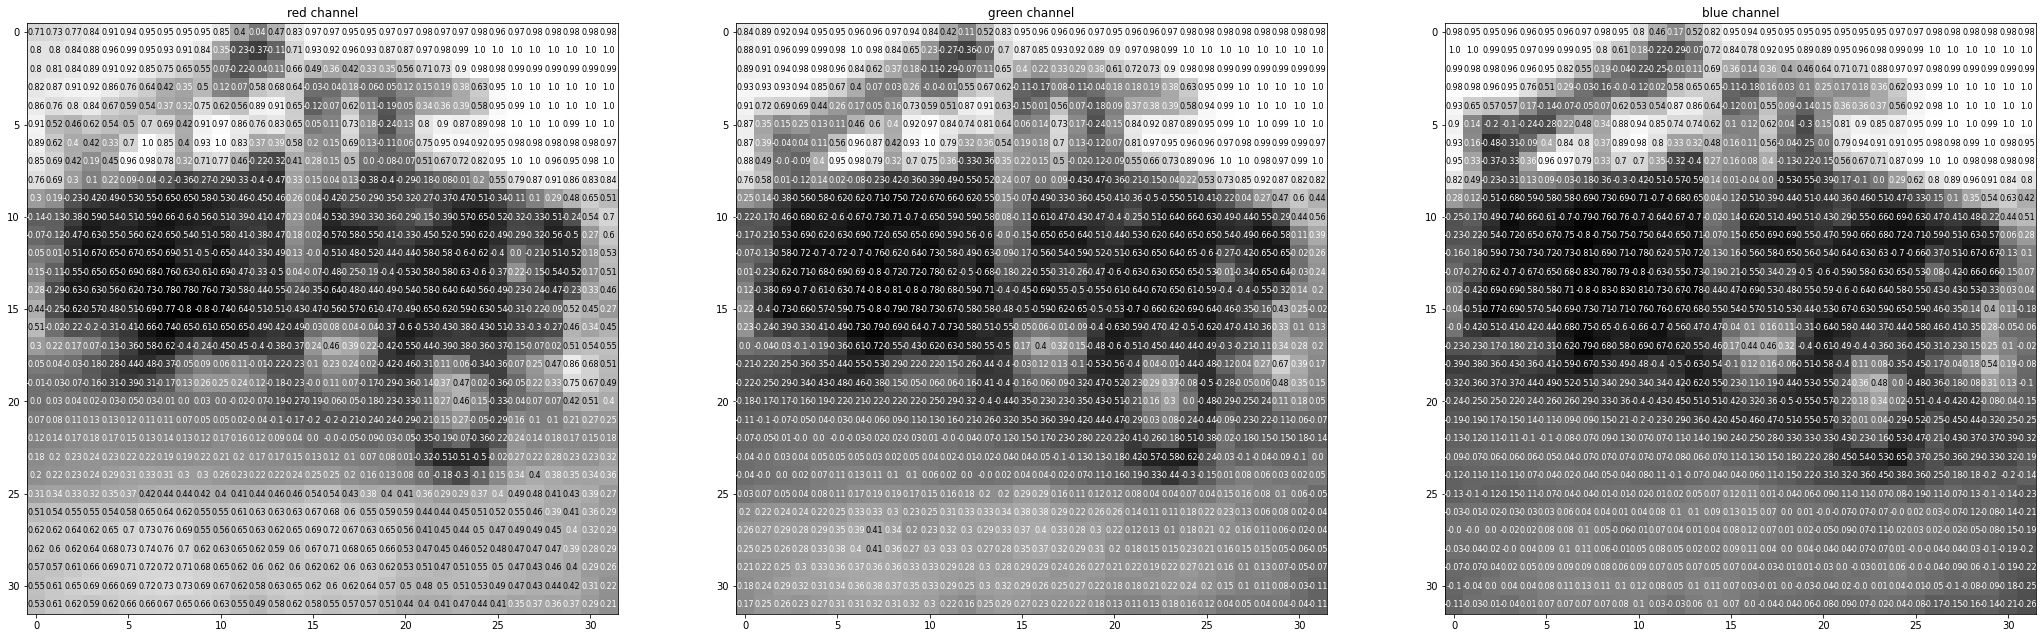

In [ ]:
### View an Image in More Detail
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

[Streaming dataloader](https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd)

It would be interesting to implement this in Future.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

In [15]:
# Testing
import torch.nn as nn
conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
con2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
con3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

In [16]:
pool1(con3(pool1(con2(pool1(conv1(imgs)))))).shape

torch.Size([20, 64, 4, 4])

In [17]:
# Defien the Network Architecture add dropout as well
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Nnet(nn.Module):
    def __init__(self):
        super(Nnet, self).__init__()
        # conv layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # fully connect layers
        self.fc1 = nn.Linear(in_features=64*4*4, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):    
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, 64*4*4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = F.softmax(x, dim=1)
        return x


In [18]:
# create a complete CNN
model = Nnet()
print(model)

Nnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [19]:
import torch.optim as optim
# specify the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)



In [20]:
def train_model(epochs, train_loader, valid_sampler, model):
    # check if gpu support is there
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    valid_loss_min = np.Inf # track change in validation loss
    # train for number of epochs
    for ep in range(1, epochs+1):

        train_loss = 0 
        valid_loss = 0
        model.to(device)
        for images, labels in train_loader:
            #print(type(images))
            images, labels = images.to(device), labels.to(device)
            # clear the gradients of all optimized variables
            #print(type(images))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model.forward(images)
            # calculate the batch loss
            loss = criterion(output, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*images.size(0)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for images, labels in valid_sampler:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = images.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
        
        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_sampler.sampler)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            ep, train_loss, valid_loss))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), f'model_cifar_ep{ep}.pt')
            valid_loss_min = valid_loss
        


In [21]:
# train the model
train_model(50, train_loader, valid_sampler, model)

cuda:0
Epoch: 1 	Training Loss: 2.250024 	Validation Loss: 2.123323
Validation loss decreased (inf --> 2.123323).  Saving model ...
Epoch: 2 	Training Loss: 2.025682 	Validation Loss: 1.982885
Validation loss decreased (2.123323 --> 1.982885).  Saving model ...
Epoch: 3 	Training Loss: 1.876436 	Validation Loss: 1.813220
Validation loss decreased (1.982885 --> 1.813220).  Saving model ...
Epoch: 4 	Training Loss: 1.772093 	Validation Loss: 1.722461
Validation loss decreased (1.813220 --> 1.722461).  Saving model ...
Epoch: 5 	Training Loss: 1.653234 	Validation Loss: 1.505388
Validation loss decreased (1.722461 --> 1.505388).  Saving model ...
Epoch: 6 	Training Loss: 1.486825 	Validation Loss: 1.469969
Validation loss decreased (1.505388 --> 1.469969).  Saving model ...
Epoch: 7 	Training Loss: 1.395949 	Validation Loss: 1.347040
Validation loss decreased (1.469969 --> 1.347040).  Saving model ...
Epoch: 8 	Training Loss: 1.232830 	Validation Loss: 1.186043
Validation loss decreased (

In [22]:
# Load the model for infernece on test data
model.load_state_dict(torch.load('model_cifar_ep43.pt'))

<All keys matched successfully>

In [23]:
# Lets implement the test cases
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for imgs, labels in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = imgs.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average validation loss 
    test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not device.type=='cuda' else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.600246

Test Accuracy of airplane: 81% (816/1000)
Test Accuracy of automobile: 92% (926/1000)
Test Accuracy of  bird: 69% (690/1000)
Test Accuracy of   cat: 62% (626/1000)
Test Accuracy of  deer: 77% (770/1000)
Test Accuracy of   dog: 72% (723/1000)
Test Accuracy of  frog: 85% (858/1000)
Test Accuracy of horse: 84% (842/1000)
Test Accuracy of  ship: 87% (874/1000)
Test Accuracy of truck: 86% (869/1000)

Test Accuracy (Overall): 79% (7994/10000)


In [29]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/cifar')

In [30]:
import matplotlib.pyplot as plt
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='CMRmap')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

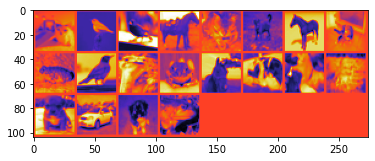

In [ ]:
import torchvision
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)